In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from mpsfm.test.simple import SimpleTest
from mpsfm.utils.tools import load_cfg
from mpsfm.vars import gvars

In [2]:
# select pipeline: mpsfm/sfm/configs
cname = "sp-mast3r-dense"
conf = load_cfg(gvars.SFM_CONFIG_DIR / f"{cname}.yaml", return_name=False)

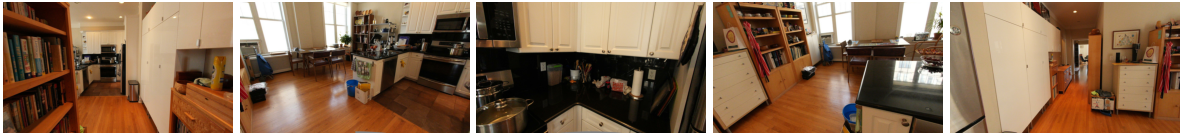

In [3]:
from mpsfm.utils.io import read_image
from mpsfm.utils.viz import plot_images, plot_keypoints

# example: 7 frames
data_dir = gvars.ROOT / "local/example"
imanmes = sorted(list((data_dir / "images").iterdir()))
plot_images([read_image(imname) for imname in imanmes], dpi=30)
plt.show()
plt.close()

In [4]:
# setup the experiment
experiment = SimpleTest(conf, data_dir=data_dir)
# reconstruct
in_imanmes = [el.name for el in imanmes]
out_rec = experiment(
    imnames=in_imanmes,
    data_dir=data_dir,
)

	STARTING RECONSTRUCTION
Extracting netvlad retrieval features...
Skipping the extraction.
Extracting retrieval pairs...
Extracting pairwise mats3r information...
Skipping the extraction.
Extracting 0 new sparse pairs
Extracting 0 new dense pairs
Extracting 0 new depth pairs
Skipping dense matching.
Extracting metric3dv2-normals normals...
Skipping the extraction.
Extracting ['sky'] masks...
No files to extract
Estimating geometry and verifying matches...


100%|██████████| 10/10 [00:00<00:00, 208.93it/s]


Initializing camera integration data...


100%|██████████| 5/5 [00:00<00:00, 25.23it/s]


(4/5) Registering and Optimizing Image 3 indoor_DSC02882.JPG                    
Ending mapper loop because all images are registered
(5/5) GLOBAL REFINEMENT                                                         
Reconstrtuction complete with (5/5) registered images
Rec has 5/5 registered images


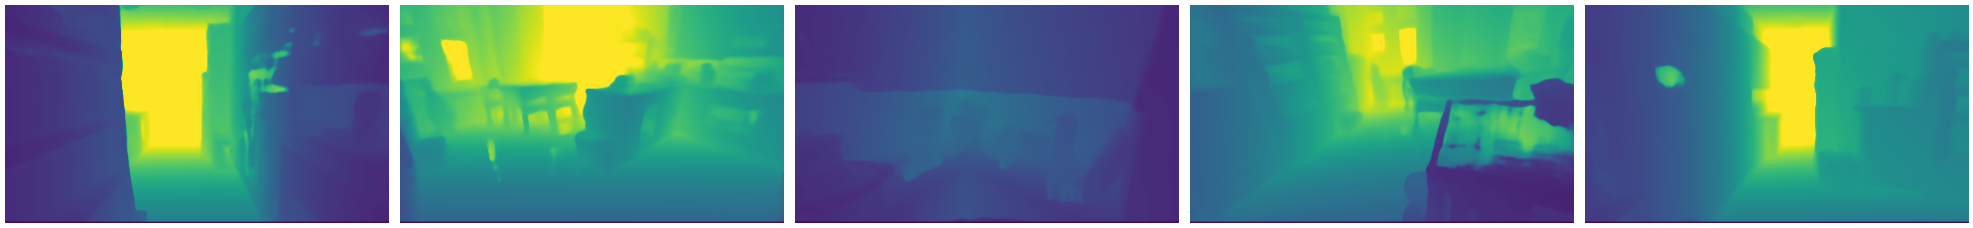

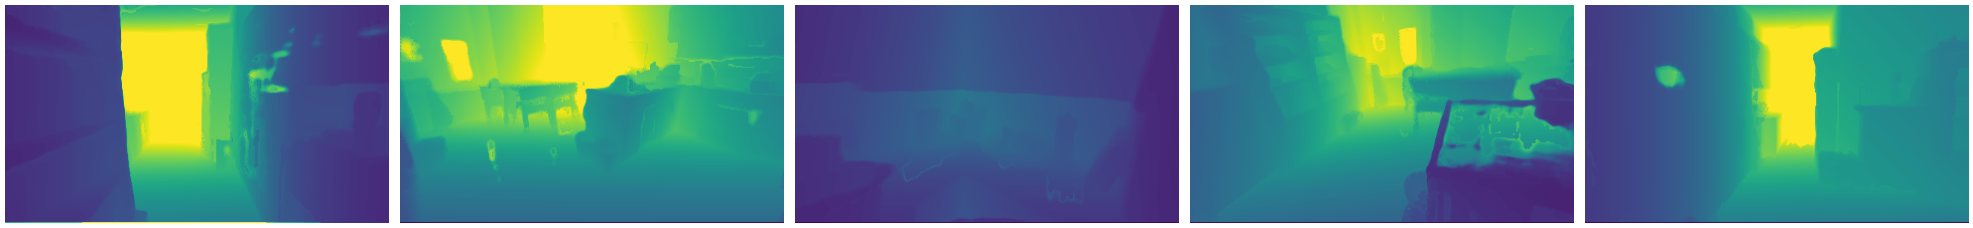

In [5]:
# Prior depths
p95 = np.percentile([image.depth.data for image in out_rec.images.values()], 95)
plot_images([image.depth.data_prior for image in out_rec.images.values()], dpi=50, cmaps="viridis", vmax=p95)
# Refined depths
plot_images([image.depth.data for image in out_rec.images.values()], dpi=50, cmaps="viridis", vmax=p95)
plt.show()
plt.close()

## Monocular Priors and Depth Refinement
To reconstruct challenging low-overlap scenes, we extend COLMAP using monocular surface priors. Monocular depth is used during absolute pose estimation and bundle adjustment to constrain low-overlap poses. To improve reconstruction quality, we refine the depth maps using normals and multi-view constraints. Below, we visualize the dense reconstruction of the scene, with the option to view both the rescaled prior depth maps and the refined depth maps.

In [ ]:
fig = out_rec.vis_depth_maps(data_dir / "images", name="refined", dmap_rescale=0.8)
fig = out_rec.vis_depth_maps(fig=fig, images_dir=data_dir / "images", name="prior", prior=True, dmap_rescale=0.8)
fig = out_rec.vis_cameras(fig)
fig.show()

## COLMAP Points
**Covariances**: Our pipeline relies on COLMAP 3D points. We compute 3D point covariances to robustly constrain depth maps during normal integration. Below, we visualize the trace of these covariances.

**Sparse vs Dense Matches**: Our pipeline offers multiple options for leveraging dense matchers. In this example, we interpolate matches around SuperPoint keypoints to build reliable multi-view tracks in salient regions. To robustly constrain poses in low-overlap scenarios, we additionally sample matches in non-salient regions, building two-view-only tracks. We also visualize the corresponding masked 3D points.

In [ ]:
# visualize sparse anchors (blue) and dense points (red)
sparse_dense_mode = "sparse_mask"
fig = out_rec.vis_colmap_points(mode=sparse_dense_mode, name=sparse_dense_mode)
uncertainty_mode = "uncert"
fig = out_rec.vis_colmap_points(fig=fig, mode=uncertainty_mode, name=uncertainty_mode)
fig = out_rec.vis_cameras(fig, color="green", name="cameras")
fig.show()

Propagated uncertainties per pixel...


  0%|          | 0/5 [00:00<?, ?it/s]

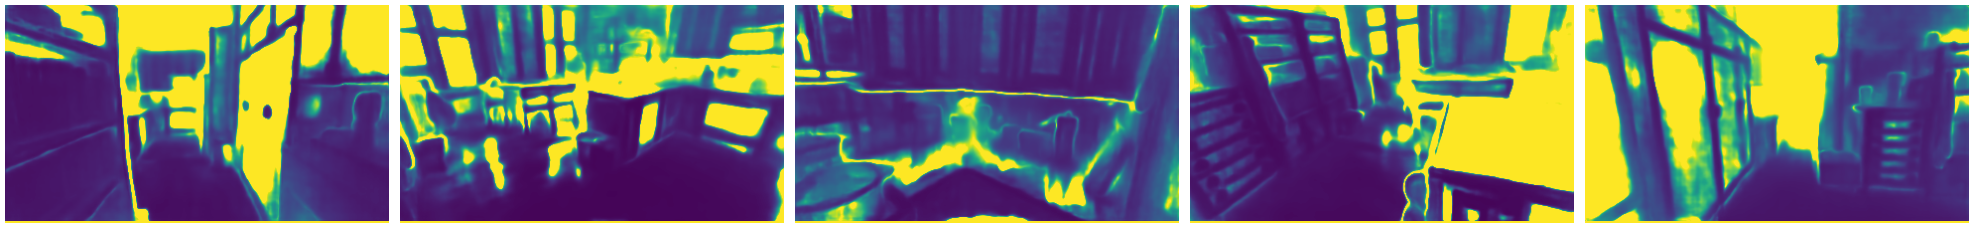

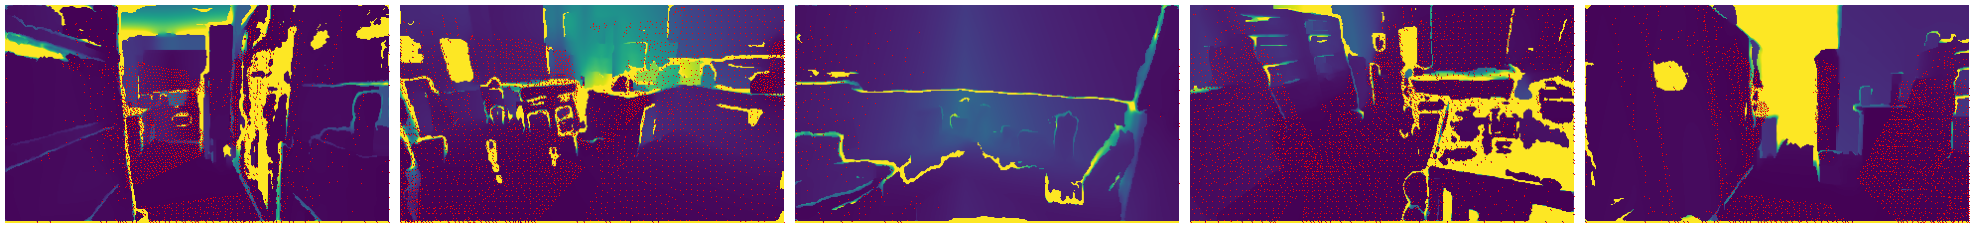

In [6]:
print("Propagated uncertainties per pixel...")
intstds = [image.calculate_int_covs_for_entire_image(False, False) for image in tqdm(out_rec.images.values())]
priorstds = [image.depth.uncertainty for image in out_rec.images.values()]

p90 = np.percentile(np.hstack(intstds), 90)

# Prior uncertainties
plot_images([std for std in priorstds], dpi=50, vmax=p90, cmaps="viridis")

# Propagated uncertainties
plot_images([std for std in intstds], dpi=50, vmax=p90, cmaps="viridis")
# Find 2D points used to optimize the depth
koords_with_3d = [image.keypoint_coords_with_3d() * image.camera.sx for image in out_rec.images.values()]
plot_keypoints(koords_with_3d, colors="r", ps=2)
plt.show()
plt.close()

In [ ]:
p80 = np.percentile(np.hstack(intstds), 80)
intcov_masks = {imid: intstds < p80 for imid, intstds in zip(out_rec.images.keys(), intstds)}
fig = out_rec.vis_depth_maps(data_dir / "images", name="refined", input_masks=intcov_masks)
fig = out_rec.vis_cameras(fig)
fig.show()